<a href="https://colab.research.google.com/github/gabriellopes3/Ativos_Financeiros/blob/main/ativos_financeiros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
! pip install pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np 
!pip install git+https://github.com/quantopian/pyfolio 
import pyfolio as pf

yf.pdr_override()

In [14]:
''' Extraindo dados do Ibovespa da web (Fonte: Yahoo finance)'''

ibovespa = pdr.DataReader('^BVSP', data_source = 'yahoo')
display(ibovespa)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0
...,...,...,...,...,...,...
2021-05-14,120719.000000,122195.000000,120719.000000,121881.000000,121881.000000,10136300
2021-05-17,121880.000000,123074.000000,121680.000000,122938.000000,122938.000000,7408100
2021-05-18,122937.000000,123544.000000,122550.000000,122980.000000,122980.000000,7840100


Text(0.5, 1.0, 'Série histórica Ibovespa')

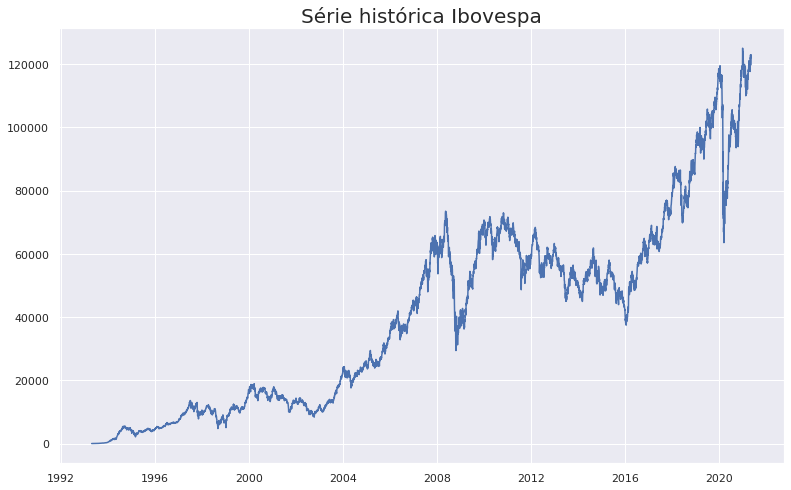

In [15]:
seaborn.set()
plt.figure(figsize = (13,8))
plt.plot(ibovespa['Close'])
plt.title('Série histórica Ibovespa', fontsize = 20)

Aumentando gradativamente o grau de dificuldade, iremos agora explanar o exemplo mais utilizado de correlação de ativos financeiros, o ibovespa e o dólar. Os dados serão extráidos pela web do yahoo finance, mas dessa vez será necessário fazer um tratamento dos dados, visto que, em um mesmo período, a quantidade de valores a serem comparados é diferente, pois há dias em que o ibovespa não se movimenta, mas o dólar sim (feriados, por exemplo). Para fazermos essa comparação, colocaremos os dados do ibovespa e do dólar em um mesmo DataFrame e eliminaremos as linhas onde existirão valores nulos (NaN).

In [16]:
ibov_dol = ['^BVSP', 'USDBRL=X']
id_df = pdr.get_data_yahoo(ibov_dol, start = '2006-01-01')['Close']
id_df = id_df.dropna()
id_df.columns = ['DÓLAR', 'IBOVESPA']
id_df['IBOV EM DÓLAR'] = id_df['IBOVESPA']/ id_df['DÓLAR']
display(id_df)

[*********************100%***********************]  2 of 2 completed


,DÓLAR,IBOVESPA,IBOV EM DÓLAR
Date,,,
2006-03-24,2.1547,37577.000000,17439.550419
2006-03-27,2.1503,37641.000000,17504.999091
2006-03-28,2.1677,36682.000000,16922.082906
2006-03-29,2.2206,37492.000000,16883.725958
2006-03-30,2.1922,37777.000000,17232.460971
...,...,...,...
2021-05-14,5.3077,121881.000000,22963.052997
2021-05-17,5.2695,122938.000000,23330.108200
2021-05-18,5.2715,122980.000000,23329.222692


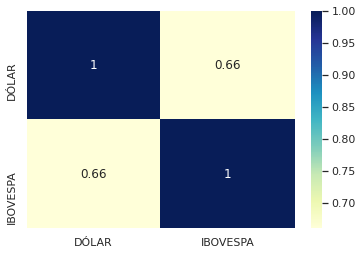

In [18]:
id_df_ = id_df.drop('IBOV EM DÓLAR', axis = 1)
seaborn.heatmap(id_df_.corr(), cmap ='YlGnBu', annot = True)

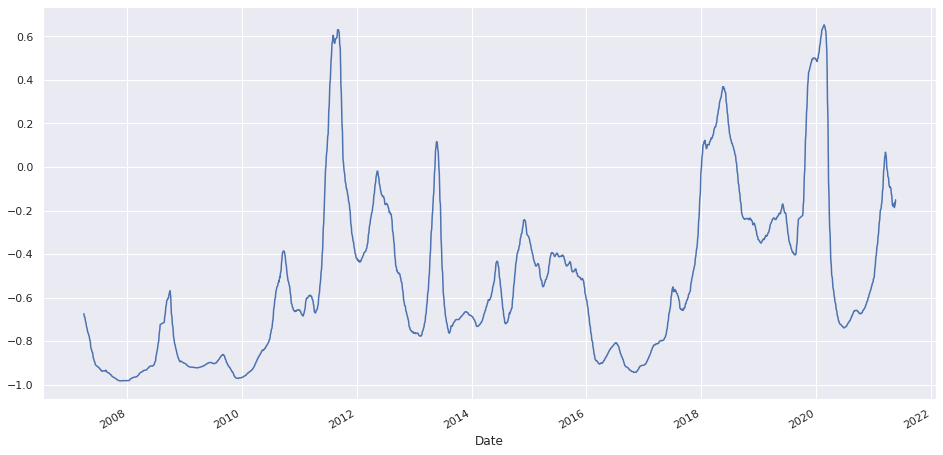

In [19]:
id_df['DÓLAR'].rolling(252).corr(id_df['IBOVESPA']).plot(figsize = (16,8)) # 252 é, aproximadamente,a quantidade dias úteis em um ano

Como podemos observar no gráfico acima, os valores chegaram a ser muito correlacionados negativamente (isto é, próximo a -1,0) durante o ano de 2008 e depois sofreu diversas variações, chegando a ficar positivamente correlacionado, mas nunca passando de 0,6.

Faremos agora um estudo da correlação entre as ações da petrobrás e a cotação do petróleo brent

In [20]:
petrobras_brent = ['PETR4.SA', 'BZ=F']
pp_df = pdr.get_data_yahoo(petrobras_brent)['Close']
pp_df = pp_df.dropna()
pp_df.columns = ['Cotação do petróleo Brent', 'Ações da Petrobrás']
display(pp_df)

[*********************100%***********************]  2 of 2 completed


,Cotação do petróleo Brent,Ações da Petrobrás
Date,,
2007-07-30,75.739998,26.799999
2007-07-31,77.050003,26.370001
2007-08-01,75.349998,26.450001
2007-08-02,75.760002,26.405001
2007-08-03,74.750000,25.200001
...,...,...
2021-05-14,68.709999,26.299999
2021-05-17,69.459999,26.660000
2021-05-18,68.709999,26.350000


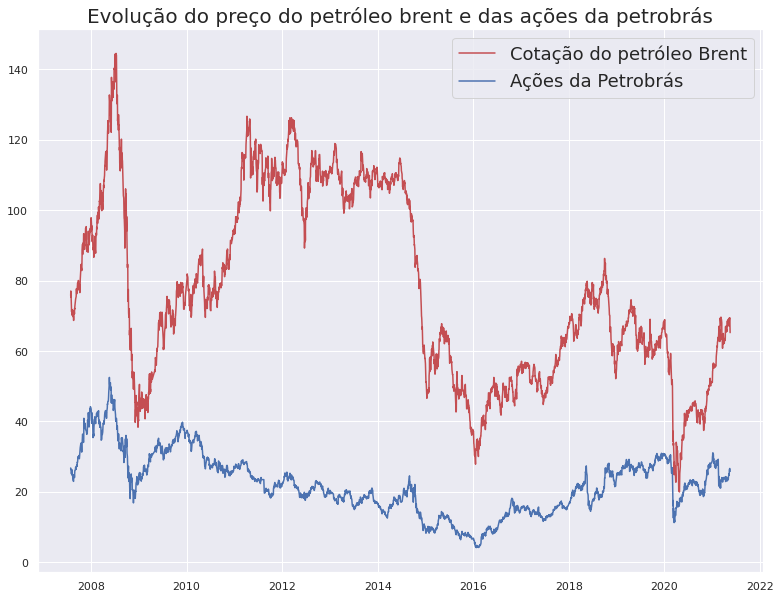

In [21]:
plt.figure(figsize = (13, 10))
plt.title('Evolução do preço do petróleo brent e das ações da petrobrás', fontsize = 20)
plt.plot(pp_df['Cotação do petróleo Brent'], label = 'Cotação do petróleo Brent', c = 'r')
plt.plot(pp_df['Ações da Petrobrás'], label = 'Ações da Petrobrás')
plt.legend(fontsize = 18)

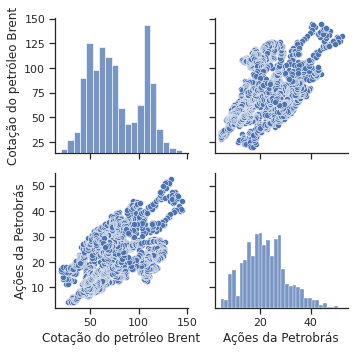

In [22]:
seaborn.set(style = 'ticks')
seaborn.pairplot(pp_df)

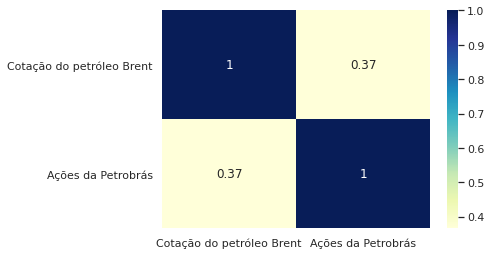

In [32]:
seaborn.heatmap(pp_df.corr(), cmap ='YlGnBu', annot = True)

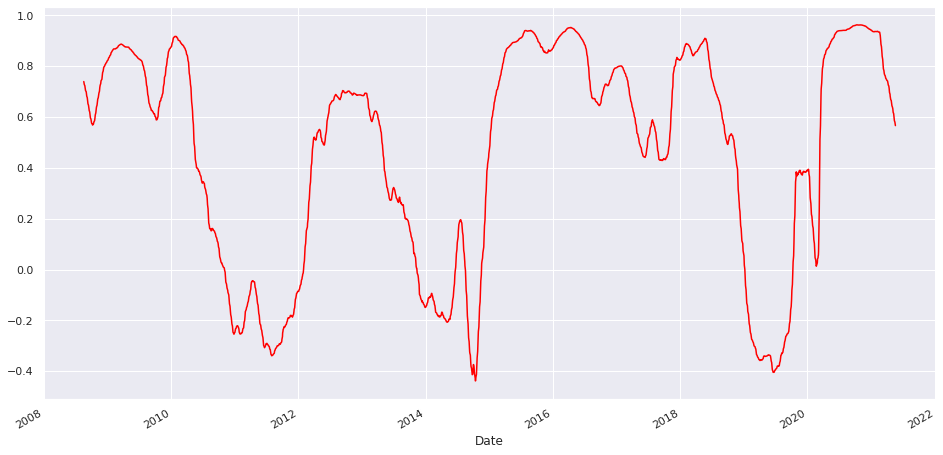

In [24]:
seaborn.set()
pp_df['Ações da Petrobrás'].rolling(252).corr(pp_df['Cotação do petróleo Brent']).plot(figsize = (16,8), c = 'red')

Com esse segundo exemplo de dois ativos que possuem uma ligação evidente (ações de um pretolífera e a cotação do barríl de petóleo) mas que, quando calculamos sua correlação, recebemos um valor abaixo do que seria "esperado" Isso se da pelo alto grau de volatilidade nos preços, ficando difícil averiguar matematicamente uma correlação, pois "Há fortes evidências de que os preços das ações, embora não sejam exatamente um passeio aleatório (random walk), estejam muito próximos disso" (Mankiw, p. 559)

In [25]:
''' Trabalhando com uma carteira de ações'''

acoes = ['VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'PETR4.SA']
carteira = pdr.get_data_yahoo(acoes, period = '8y')['Close']
carteira.dropna()
display(carteira)

x = ['^BVSP', '^IBX50']
ibov_ibrx = pdr.get_data_yahoo(x, period = '8y')['Close']
ibov_ibrx.dropna()
display(ibov_ibrx)

[*********************100%***********************]  5 of 5 completed


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,17.178419,16.482443,14.712109,20.200001,32.889999
2013-05-21,17.096428,16.567820,16.443775,20.250000,33.150002
2013-05-22,16.956440,16.629480,16.659153,19.920000,32.619999
2013-05-23,16.864449,16.401810,16.518908,19.860001,32.009998
2013-05-24,16.768457,16.278486,16.468821,20.090000,31.700001
...,...,...,...,...,...
2021-05-14,17.180000,24.889999,29.000000,26.299999,110.559998
2021-05-17,17.400000,25.000000,28.980000,26.660000,113.459999
2021-05-18,17.420000,25.400000,28.920000,26.350000,114.599998


[*********************100%***********************]  2 of 2 completed


,^BVSP,^IBX50
Date,,
2013-05-20,55701.000000,8995.339844
2013-05-21,56265.000000,9042.870117
2013-05-22,56429.000000,9018.190430
2013-05-23,56350.000000,8958.040039
2013-05-24,56406.000000,8945.540039
...,...,...
2021-05-14,121881.000000,20510.019531
2021-05-17,122938.000000,20745.910156
2021-05-18,122980.000000,20784.839844


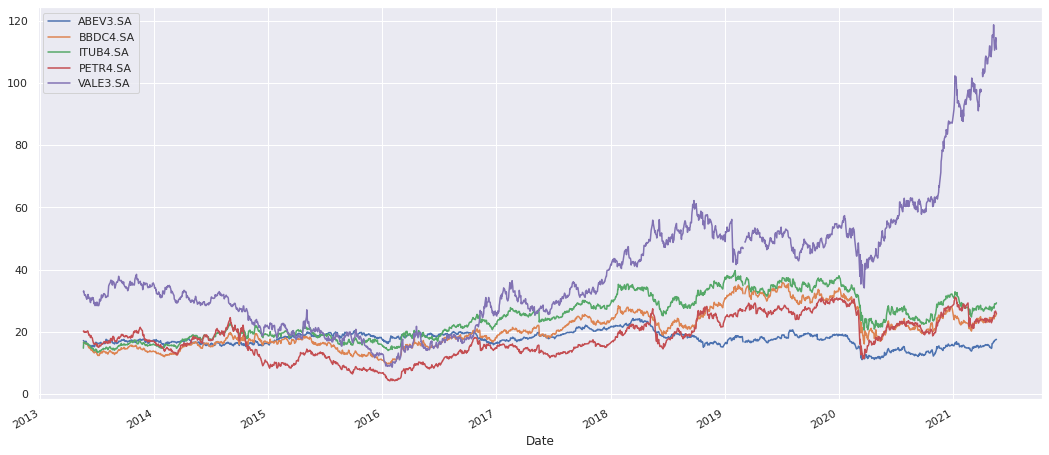

In [26]:
seaborn.set()
carteira.plot(figsize = (18,8))

A seguir, faremos um exemplo calculando o retorno e o desvio padrão desta mesma carteira. Depois, calcularemos o saldo desta carteira admitindo que um investidor comprou R$ 5.000,00 de cada uma destas ações, seguidamente iremos comparar os rendimentos dessa carteira com o ibovespa e o ibrx.

In [27]:
retorno = carteira.pct_change()
display(retorno)

retorno_acum = (retorno + 1).cumprod()
retorno_acum.iloc[0] = 1
display(retorno_acum)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,NaN,NaN,NaN,NaN,NaN
2013-05-21,-0.004773,0.005180,0.117703,0.002475,0.007905
2013-05-22,-0.008188,0.003722,0.013098,-0.016296,-0.015988
2013-05-23,-0.005425,-0.013691,-0.008419,-0.003012,-0.018700
2013-05-24,-0.005692,-0.007519,-0.003032,0.011581,-0.009684
...,...,...,...,...,...
2021-05-14,0.017773,0.009327,0.022207,0.052421,-0.017157
2021-05-17,0.012806,0.004419,-0.000690,0.013688,0.026230
2021-05-18,0.001149,0.016000,-0.002070,-0.011628,0.010048


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,1.000000,1.000000,1.000000,1.000000,1.000000
2013-05-21,0.995227,1.005180,1.117703,1.002475,1.007905
2013-05-22,0.987078,1.008921,1.132343,0.986139,0.991791
2013-05-23,0.981723,0.995108,1.122810,0.983168,0.973244
2013-05-24,0.976135,0.987626,1.119406,0.994554,0.963819
...,...,...,...,...,...
2021-05-14,1.000092,1.510092,1.971165,1.301980,3.361508
2021-05-17,1.012899,1.516765,1.969806,1.319802,3.449681
2021-05-18,1.014063,1.541034,1.965728,1.304455,3.484342


In [28]:
''' Calculando o desvio Padrão (DP) de cada ação da carteira'''

dp = retorno.std()
print(dp)

ABEV3.SA    0.017023
BBDC4.SA    0.023464
ITUB4.SA    0.021008
PETR4.SA    0.033142
VALE3.SA    0.029198
dtype: float64


In [29]:
ex_carteira = (carteira / carteira.iloc[0]) * 5000
ex_carteira['SALDO'] = ex_carteira.sum(axis = 1)
ex_carteira = ex_carteira.loc[ex_carteira['SALDO'] > 0]
ex_carteira['RETORNO'] = ex_carteira['SALDO'].pct_change()
ex_carteira.dropna()
display(ex_carteira)
ex_ibov_ibrx = ibov_ibrx / ibov_ibrx.iloc[0] * 25000
display (ex_ibov_ibrx)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,SALDO,RETORNO
Date,,,,,,,
2013-05-20,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,25000.000000,NaN
2013-05-21,4976.135407,5025.899298,5588.517462,5012.376048,5039.526017,25642.454233,0.025698
2013-05-22,4935.390114,5044.604282,5661.714926,4930.692902,4958.954019,25531.356243,-0.004333
2013-05-23,4908.614825,4975.539681,5614.051657,4915.841550,4866.220571,25280.268284,-0.009834
2013-05-24,4880.675370,4938.129134,5597.029293,4972.772127,4819.094155,25207.700079,-0.002871
...,...,...,...,...,...,...,...
2021-05-14,5000.460226,7550.458269,9855.827184,6509.900555,16807.540227,45724.186461,0.008871
2021-05-17,5064.493858,7583.827294,9849.029907,6599.009614,17248.403951,46344.764624,0.013572
2021-05-18,5070.315249,7705.168415,9828.638722,6522.277076,17421.708817,46548.108279,0.004388


,^BVSP,^IBX50
Date,,
2013-05-20,25000.000000,25000.000000
2013-05-21,25253.137287,25132.096936
2013-05-22,25326.744583,25063.506733
2013-05-23,25291.287410,24896.335755
2013-05-24,25316.421608,24861.595544
...,...,...
2021-05-14,54703.236926,57001.791726
2021-05-17,55177.644926,57657.382924
2021-05-18,55196.495575,57765.576968


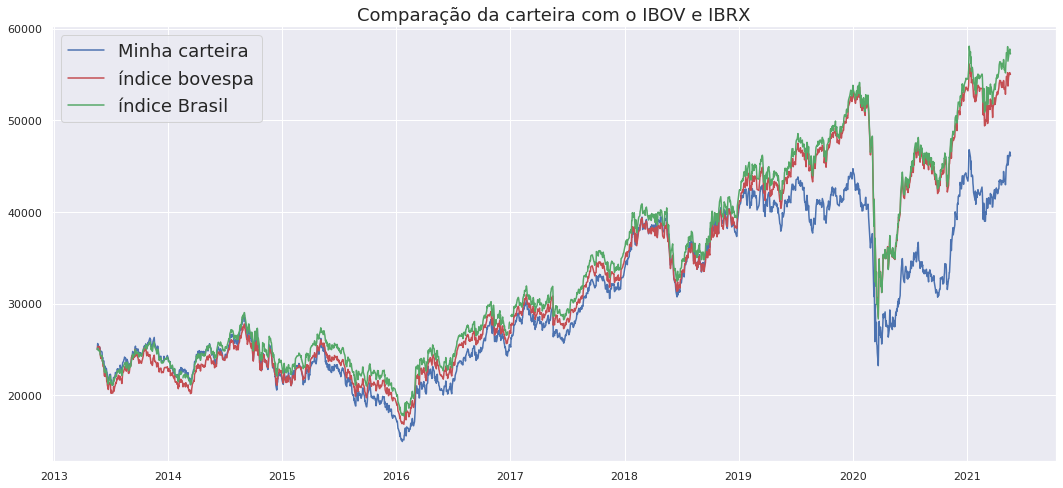

In [30]:
seaborn.set()
plt.figure(figsize = (18,8))
plt.title('Comparação da carteira com o IBOV e IBRX', fontsize = 18)
plt.plot(ex_carteira['SALDO'], label = 'Minha carteira')
plt.plot(ex_ibov_ibrx['^BVSP'], label = 'índice bovespa', color = 'r')
plt.plot(ex_ibov_ibrx['^IBX50'], label = 'índice Brasil', color = 'g')
plt.legend(fontsize = 18)
plt.show()

Start date,2013-05-20
End date,2021-05-20
Total months,94
,Backtest
Annual return,8.084%
Cumulative returns,84.413%
Annual volatility,29.202%
Sharpe ratio,0.41
Calmar ratio,0.17
Stability,0.64
Max drawdown,-48.079%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.08,2014-09-02,2016-01-21,2017-01-24,626
1,48.06,2020-01-02,2020-03-23,2021-01-06,265
2,23.04,2018-05-16,2018-06-18,2018-11-05,124
3,19.60,2013-11-18,2014-03-14,2014-07-18,175
4,17.77,2013-05-21,2013-07-08,2013-10-29,116


Stress Events,mean,min,max
Apr14,0.11%,-2.53%,2.91%
Oct14,0.06%,-4.04%,6.79%
Fall2015,-0.14%,-3.14%,4.72%
New Normal,0.05%,-13.55%,15.71%


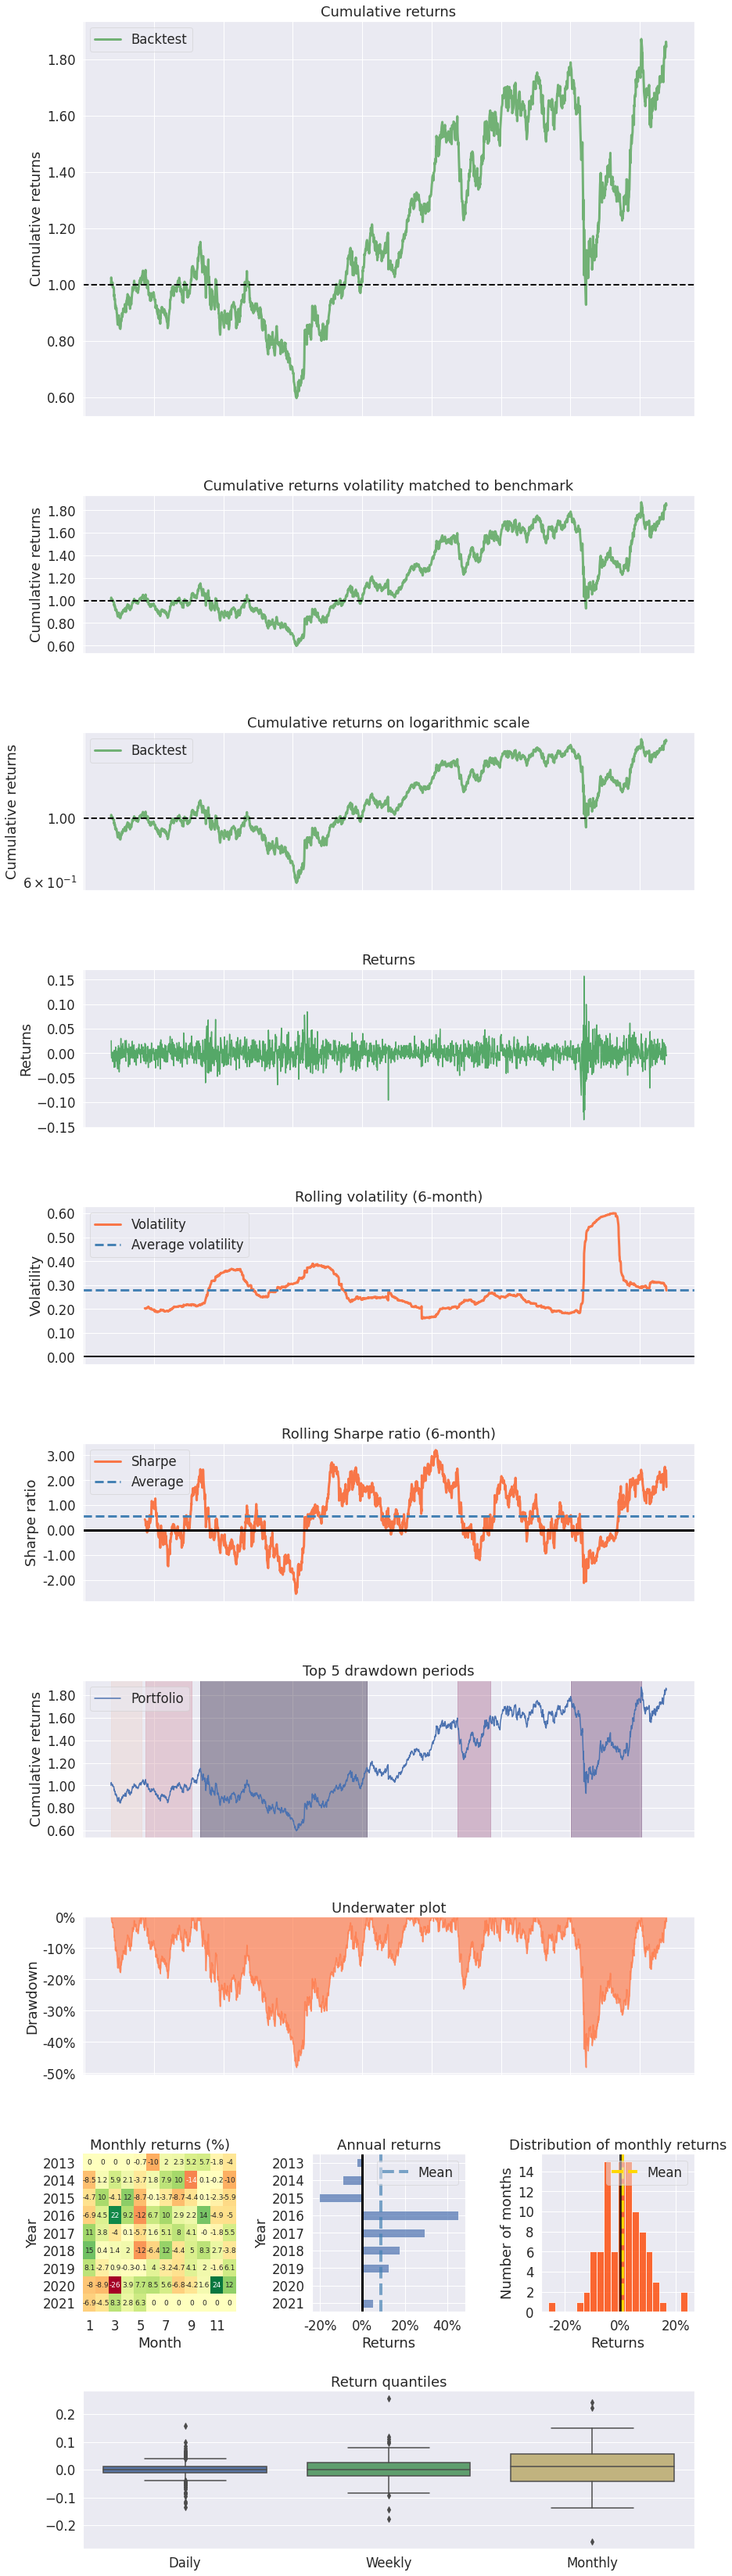

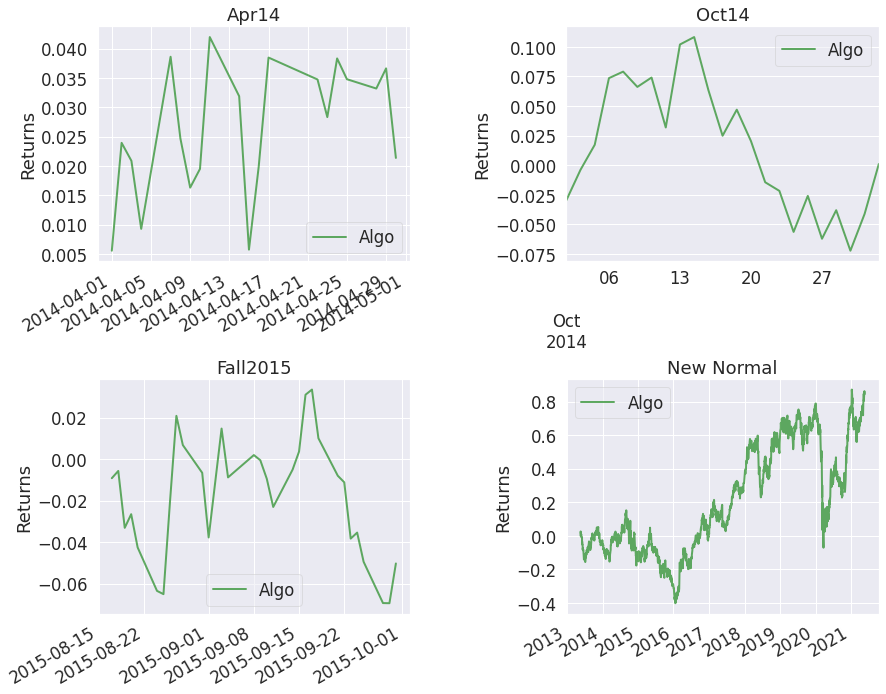

In [33]:
'' 'Backtesting da carteira com o pyfolio '''

pf.create_full_tear_sheet(ex_carteira['RETORNO'])